In [89]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score

In [90]:
df_wine = pd.read_csv('winequality-red.csv')
df_attributes = df_wine.drop(columns = 'quality')
print(df_attributes.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


## Caracterización de las Calidades del Vino

In [91]:
lista_quality = list(df_wine['quality'].unique())
print(lista_quality)

[5, 6, 7, 4, 8, 3]


In [92]:
# El vino de alta calidad contiene valores bajos de acido cítrico y baja variación en la acidez
df_q8 = df_wine[df_wine['quality'] == 8]
df_q8 = df_q8[['fixed acidity','volatile acidity','citric acid','quality']]
df_q8 = df_q8.groupby(by = ['quality']).agg(['min','mean','max'])
print(df_q8)

        fixed acidity                 volatile acidity                  \
                  min      mean   max              min      mean   max   
quality                                                                  
8                 5.0  8.566667  12.6             0.26  0.423333  0.85   

        citric acid                  
                min      mean   max  
quality                              
8              0.03  0.391111  0.72  


## Análisis Correlacional de las Variables

In [93]:
df_wine_corr = df_wine.corr()
print(df_wine_corr)

                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.256131     0.671703   
volatile acidity          -0.256131          1.000000    -0.552496   
citric acid                0.671703         -0.552496     1.000000   
residual sugar             0.114777          0.001918     0.143577   
chlorides                  0.093705          0.061298     0.203823   
free sulfur dioxide       -0.153794         -0.010504    -0.060978   
total sulfur dioxide      -0.113181          0.076470     0.035533   
density                    0.668047          0.022026     0.364947   
pH                        -0.682978          0.234937    -0.541904   
sulphates                  0.183006         -0.260987     0.312770   
alcohol                   -0.061668         -0.202288     0.109903   
quality                    0.124052         -0.390558     0.226373   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity    

In [94]:
# Crear el gráfico de correlación
fig = px.imshow(df_wine_corr, 
                text_auto=True,  # Muestra los valores de correlación en las celdas
                color_continuous_scale='Viridis',
                title="Matriz de Correlación")

# Ajustar el tamaño del lienzo
fig.update_layout(
    width=1000,  # Ancho del lienzo
    height=1000  # Alto del lienzo
)

# Mostrar el gráfico
fig.show()

## Análisis de Componentes Principales - PCA

In [95]:
# Estandariza los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_attributes)

# Aplicar PCA
pca = PCA(n_components=11)
principal_components = pca.fit_transform(df_scaled)

# Crear un DataFrame con los componentes principales
df_pca = pd.DataFrame(data=principal_components, columns=df_attributes.columns)

# Varianza explicada por cada componente
print(pca.explained_variance_ratio_)

# Base para el KMeans (para fines gráficos, se seleccionan 3 características principales)
df_pca = df_pca.iloc[:,:3]
print(df_pca)

[0.28173931 0.1750827  0.1409585  0.11029387 0.08720837 0.05996439
 0.05307193 0.03845061 0.0313311  0.01648483 0.00541439]
      fixed acidity  volatile acidity  citric acid
0         -1.619530          0.450950    -1.774454
1         -0.799170          1.856553    -0.911690
2         -0.748479          0.882039    -1.171394
3          2.357673         -0.269976     0.243489
4         -1.619530          0.450950    -1.774454
...             ...               ...          ...
1594      -2.150500          0.814286     0.617063
1595      -2.214496          0.893101     1.807402
1596      -1.456129          0.311746     1.124239
1597      -2.270518          0.979791     0.627965
1598      -0.426975         -0.536690     1.628955

[1599 rows x 3 columns]


## Clusterización mediante K-Means

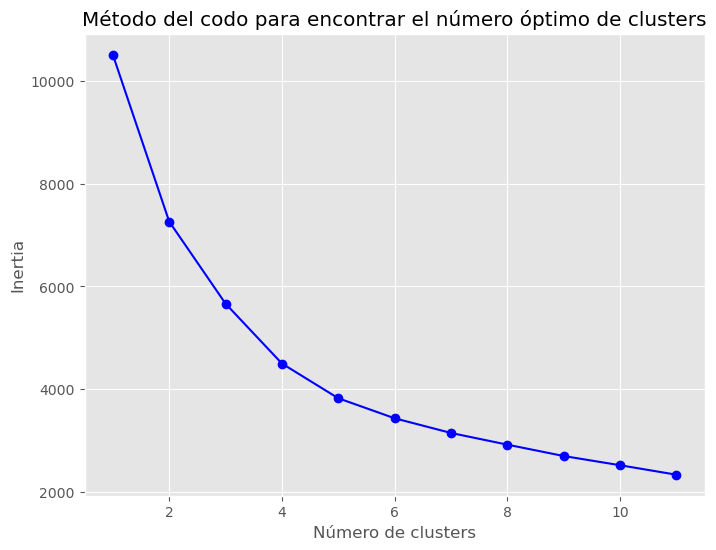

In [96]:
# Método del codo
def elbow_method(df):
    inertia = []
    K = range(1, 12)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inertia')
    plt.title('Método del codo para encontrar el número óptimo de clusters')
    plt.show()

elbow_method(df_pca)

In [100]:
# Inicializar el modelo K-means
kmeans = KMeans(n_clusters=5, random_state=42)

# Ajustar el modelo a los datos
kmeans.fit(df_pca)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Agregar las etiquetas de los clusters al dataframe original
df_pca['Cluster'] = labels

# Ajustar el tamaño del lienzo
fig.update_layout(
    width=500,  # Ancho del lienzo
    height=1000  # Alto del lienzo
)

fig = px.scatter_3d(df_pca, x='fixed acidity', y='volatile acidity', z='citric acid',
              color='Cluster', size_max = 30, template = 'plotly_dark')
fig.show()

## Modelo de Regresión Múltiple Lineal

Número óptimo de características: 11
Características seleccionadas: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
Mean Squared Error (RFECV): 0.39002514396395405
R^2 Score (RFECV): 0.4031803412796232

Modelo de Regresión Lineal:
Intercept: 14.355105195761976
Coeficientes: [ 2.30853339e-02 -1.00130443e+00 -1.40821461e-01  6.56431104e-03
 -1.80650315e+00  5.62733439e-03 -3.64444893e-03 -1.03515936e+01
 -3.93687732e-01  8.41171623e-01  2.81889567e-01]

Coeficientes del Modelo:
                      Coeficiente
fixed acidity            0.023085
volatile acidity        -1.001304
citric acid             -0.140821
residual sugar           0.006564
chlorides               -1.806503
free sulfur dioxide      0.005627
total sulfur dioxide    -0.003644
density                -10.351594
pH                      -0.393688
sulphates   

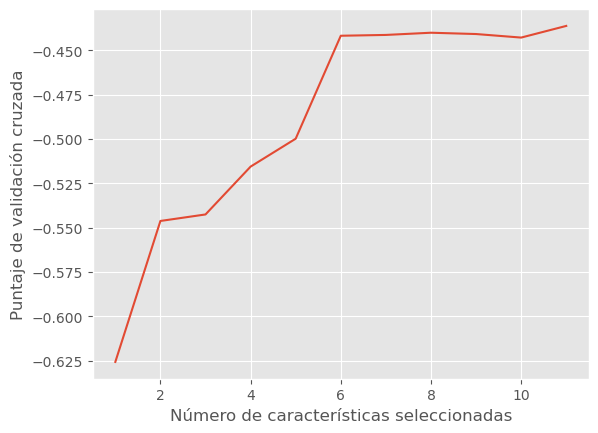

In [105]:
# Separar las variables predictoras (X) y la variable de respuesta (y)
X = df_wine.drop(columns=['quality'])
y = df_wine['quality']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()

# Selección recursiva de características con validación cruzada (RFECV)
rfecv = RFECV(estimator=model, step=1, cv=10, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features_rfecv = X.columns[rfecv.support_]

# Crear un nuevo conjunto de datos con las características seleccionadas
X_train_selected_rfecv = rfecv.transform(X_train)
X_test_selected_rfecv = rfecv.transform(X_test)

# Entrenar el modelo con las características seleccionadas
model_selected_rfecv = LinearRegression()
model_selected_rfecv.fit(X_train_selected_rfecv, y_train)

# Predecir con el conjunto de prueba
y_pred_rfecv = model_selected_rfecv.predict(X_test_selected_rfecv)

# Evaluar el modelo
mse_rfecv = mean_squared_error(y_test, y_pred_rfecv)
r2_rfecv = r2_score(y_test, y_pred_rfecv)

# Mostrar los resultados
print("Número óptimo de características:", rfecv.n_features_)
print("Características seleccionadas:", selected_features_rfecv)
print("Mean Squared Error (RFECV):", mse_rfecv)
print("R^2 Score (RFECV):", r2_rfecv)

print("\nModelo de Regresión Lineal:")
print("Intercept:", model_selected_rfecv.intercept_)
print("Coeficientes:", model_selected_rfecv.coef_)

# Crear un DataFrame para visualizar los coeficientes con las características seleccionadas
coef_df = pd.DataFrame(model_selected_rfecv.coef_, index=selected_features_rfecv, columns=["Coeficiente"])
print("\nCoeficientes del Modelo:")
print(coef_df)

# Graficar el número de características vs. el puntaje de validación cruzada
plt.figure()
plt.xlabel("Número de características seleccionadas")
plt.ylabel("Puntaje de validación cruzada")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()